Before running the code, make sure to download the dataset and the model checkpoint in your local machine.

The model checkpoint can be downloaded here: https://www.dropbox.com/s/uth8ppqttf9c2wv/checkpoint?dl=0
The processed dataset can be downloaded here: https://www.dropbox.com/s/msj3amctgtbkodb/norm_brain_dataset_np_float32.npy?dl=0

Please store the data file as /data/brain-dataset/layer6_norm_brain_dataset_np_float32.npy or change the source file datapath otherwise.

Please download and store dataset.py, model.py, utils.py.

In [5]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

from dataset import return_data_sp
from model import BetaVAE_Brain
from utils import cuda, DataGather

warnings.filterwarnings("ignore")

ckpt_path = os.path.join("checkpoints", "checkpoint")

Define model evaluation solver and define visualization function.

In [9]:
class compare_and_evaluation(object):
    def __init__(self, z_dim=8, beta=3, dataset="brain"):
        data_loader = return_data_sp(dataset) # shuffle=True so they are random images
        self.z_dim = z_dim
        self.beta = beta
        self.data_loader = data_loader
        self.use_cuda = True
        self.ckpt_path = ckpt_path

        self.beta_VAE_model = cuda(BetaVAE_Brain(z_dim=self.z_dim, nc=1), self.use_cuda)
        self.gather_beta_VAE = DataGather()
        self.imagestore_beta_VAE = {"original":[], "recon":[]}
        
        self.global_iter = 0

    def load_beta_VAE(self):
        if os.path.isfile(self.ckpt_path):
            checkpoint = torch.load(self.ckpt_path)
            ###
            self.beta_VAE_model.load_state_dict(checkpoint['model_states']['net'])
            global_iter = checkpoint['iter']
            print("=> loaded checkpoint '{} (iter {})'".format(self.ckpt_path, global_iter))
        else:
            print("=> no checkpoint found at '{}'".format(self.ckpt_path))

    def viz_traverse(self, limit=7, inter=1):
        self.load_beta_VAE()
        decoder = self.beta_VAE_model.decoder
        encoder = self.beta_VAE_model.encoder
        interpolation = torch.arange(-limit, limit+0.0001, inter)

        fixed_idx_list = [2] # = 5
        multi_samples = []
        for fixed_idx in fixed_idx_list:
            fixed_img = self.data_loader.dataset.__getitem__(fixed_idx)
            fixed_img = Variable(cuda(fixed_img, self.use_cuda), volatile=True).unsqueeze(0)
            fixed_img_z = encoder(fixed_img)[:, :self.z_dim]
            Z = {'fixed_img':fixed_img_z} # get the fixed_img_z


            z_ori = Z["fixed_img"]
            samples = []
            for row in (range(self.z_dim)): # dimension of 8
                sample_row = []
                z = z_ori.clone()
                for val in tqdm(interpolation):
                    z[:, row] = val # for example: change part of random_z
                    sample = F.sigmoid(decoder(z)).data
                    sample = np.squeeze(sample.cpu().numpy())
                    sample = sample.transpose()
                    sample_row.append(sample)
                samples.append(sample_row)
            samples = np.array(samples)
            print(samples.shape)
            
        return samples

In [10]:
def heatmaps(samples, mode = "checkfile"):
    if mode == "checkfile":
        fig, axes = plt.subplots(nrows=2, ncols=4, subplot_kw={'xticks': [], 'yticks': []})
        data = samples # (8, 2801, 320, 448)
        for latent_i in range(8):
            data_latent = data[latent_i,:,:,:]
            print(data_latent.shape)
            data_var = np.var(data_latent,axis=0)
            if latent_i<4:
                axes[0,latent_i].imshow(data_var,cmap="magma")
            else:
                axes[1, latent_i-4].imshow(data_var, cmap="magma")
        plt.tight_layout()
        plt.show()
    elif mode == "checkimages":
        fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(10,15), subplot_kw={'xticks': [], 'yticks': []})
        data = samples
        for latent_i in range(8):
            data_latent = data[latent_i, :, :, :]
            show_list = [350, 1050, 1750, 2450]
            data_latent_show = data_latent[show_list,:,:]
            for images in range(4):
                axes[latent_i,images].imshow(data_latent_show[images,:,:],cmap="magma")

        plt.show()

brain_data_shape:torch.Size([1723, 1, 448, 320])
=> loaded checkpoint 'checkpoints\checkpoint (iter 10000)'
fixed_img_z torch.Size([1, 8])


100%|██████████| 15/15 [00:00<00:00, 601.62it/s]


(8, 15, 320, 448)
(15, 320, 448)
(15, 320, 448)
(15, 320, 448)
(15, 320, 448)
(15, 320, 448)
(15, 320, 448)
(15, 320, 448)
(15, 320, 448)


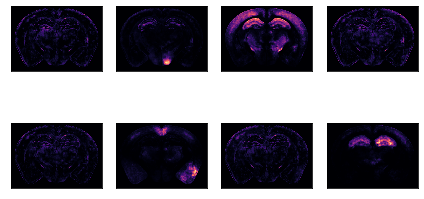

In [11]:
visualizer = compare_and_evaluation()
samples = visualizer.viz_traverse()
heatmaps(samples)